## Prevendo a Probabilidade de Ocorrência de Graves Acidentes de Trabalho Usando a Técnica Ensembles de Machine Learning

![oi](esemble.png)

## Sumário

* [Introdução](#1)
* [Preparando os Dados](#2)
* [Ensemble Machine Learning](#3)
   - [One Level](#4)
   - [Secund Level](#5)
* [Ensemble Machine Learning](#6)
* [Criando Dataframe Com as Previsões](#7)
* [Conclusão](#8)

## Introdução <a id= "1"></a>

Desenvolver um ambiente de trabalho protetor e o mais seguro possível é um dos principais desafios enfrentados pelas companhias. Principalmente Em setores pesados da indústria, onde o risco de acidente fatal é bem maior que nos demais setores. Naturalmente, a busca de ambiente de trabalho com alta prioridade de segurança pode custar um parte significativa da receita de uma companhia. Logo, buscar novas técnicas e tecnologias que aumente a eficiência da gestão de segurança do trabalho e ao mesmo tempo reduza os custos de implementação é imprescindível. Com este intuito, construir modelos de previsão que possam mostrar a probabilidade de ocorrência de determinados eventos de risco é uma estratégia muito empregada atualmente. Modelos de machine learning são muito bons em classificar e prever a probabilidade de eventos de risco. Contudo, devido a natureza delicada de se prever a possibilidade de um funcionário sofrer um acidente fatal, precisamos de modelos realmente confiáveis. Sabemos que um único modelo de machine laerning esta sujeito a eventos que podem reduzir ou invalidar suas previsões. Entre esses eventos temos os mais comuns que são o overfiting e underfiting. Além disso temos a possiblidade das features do dataset ser bastante heterogênea de modo que o modelo pode ter um desempenho melhor para determinadas partes do dataset do que em outras. 

Nosso objetivo é construir um modelo de classificação que possa prever com alta confiabilidade o 'grau de lesão' evitando a maioria dos problemas citados acima. Por isso faremos uso de esemble de machine learnig do tipo stacking que usa a previsão de vários modelos de machine leaining para gerar dados para validação posterior de outros modelos. Normalmente quando queremos validar informações que possuímos comparamos com outras fontes que possuem a mesma informação. Para uma visão mais detalhada do conceito ensemble pode ser encontrado aqui: [ensemble-learning-bagging-boosting-stacking](https://www.kaggle.com/satishgunjal/ensemble-learning-bagging-boosting-stacking). Quanto mais fontes puderem validar a nossa informação prévia mais certos estaremos. Esta é a forma básica de como a técnica dos esembles funciona, com isso esperamos aumentar a confiança na previsão dos nossos modelos. Mais especificamente nosso esemble terá dois níveis, onde rodamos um conjunto de modelos no primeiro nível e usamos as predições deste nível para treinar um modelo no segundo nível. De modo que o modelo de segundo nível deve ter um desepenho melhor e mais confiável que um único modelo.

A nossa base de dados que usaremos neste notebook foi obtida do dataset original onde este consistia de uma série de colunas categóricas e numéricas que mostrava várias informações sobre os empregados que sofreram lesões fatais e não-fatais. O dataset original pode encontrado neste link: [Osha-accident-and-injury-data](https://www.kaggle.com/ruqaiyaship/osha-accident-and-injury-data-1517). Após as transformações adequadas para a limpeza do dataset, convertemos as features categóricas em novas colunas usando o OneHotEncoder(). Com os dados limpos em mãos tentaremos responder a seguinte questão: dado uma série de features associadas a um empregado que sofreu um acidente qual probabilidade do mesmo sobreviver ou não ao um determinado acidente de trabalho. Para avaliar todos os modelos utilizados neste notebook usaremos a métrica log-loss e a métrica ROC-AUC. A log-loss é a melhor métrica para avaliar classificação com base nas probabilidades das previsões. Além disso a log-loss é muito boa para compararmos modelos com outros, quando menor o valor da log-loss melhor será o modelo. Já ROC-AUC basicamente nos diz o quão bem o modelo conseguie separar as classes alvos. 50% de ROC-AUC significa que o modelo não consegue distinguir entre as classes alvos, enquanto que  em 100% o modelo separa com perfeição as classes alvos.

In [1]:
# Importando as bibliotecas necessárias
import pandas as pd
import os
import time
import random
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler 
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from colorama import Fore, Back, Style 

import warnings
warnings.filterwarnings("ignore")

## Preparando os Dados <a id= "2"></a>

In [2]:
# Lendo os dados do dataset previamente limpo.
df = pd.read_csv('oblivion.csv')
df.head(3)

,Degree of Injury,0,1,2,3,4,5,6,7,8,...,148,149,150,build_stor,nature_of_inj,evn_factor,fat_cause,Year,Month,Day
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0,1,2,0,2017,8,10
1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1,9,18,0,2017,7,17
2,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0,5,18,0,2017,6,30


Nossa variável alvo é a coluna categórica 'Degree of Injury' que contem duas classes para nível do lesão que os empregados sofreram. A classe com valor 0 representada os empregados que sobreviveram ao acidente de trabalho, enquanto a classe com valor 1 representa os empregados que não sobreviveram.

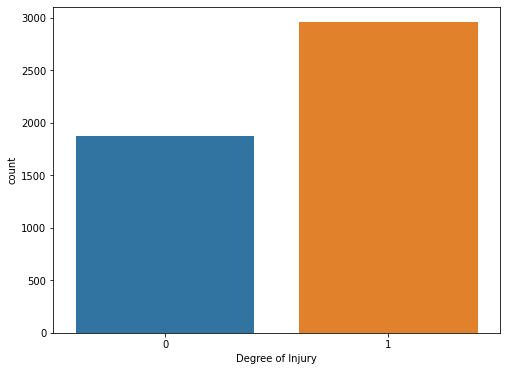

In [3]:
# Verificando o desbalanceamento das classes 0 e 1 do 'Degree of Injury'.
plt.figure(figsize=(8, 6))
sns.countplot(x = df['Degree of Injury']);

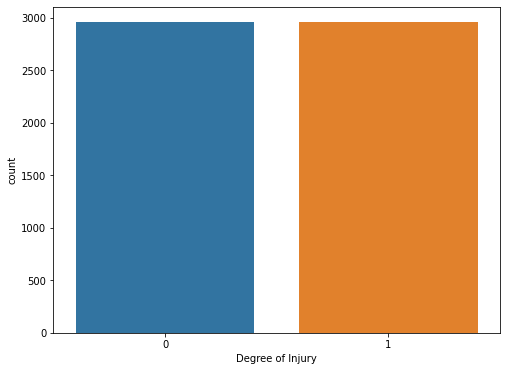

In [4]:
# Dividindo o dataset em uma parte que representa as variáveis independentes (features) e uma parte que representa  uma variável dependnete (target).
X = df.drop('Degree of Injury', axis = 1)
y = df['Degree of Injury']

# Balanceando as classes criando uma amostra da classe '0'.
Over_sampler = RandomOverSampler()
X0, y0 = Over_sampler.fit_resample(X, y)

# Plotando as classes balanceadas
plt.figure(figsize=(8, 6))
np.bincount(y0)
ax = sns.countplot(x=y0)

# Normalizando as features
scaler = MinMaxScaler()
X =  scaler.fit_transform(X0)
X = pd.DataFrame(X0)

## Ensemble Machine Learning <a id= "3"></a>

### Primeiro Nível <a id= "4"></a>

In [5]:
# Dedinindo o conjunto de modelos de nível um.

# Criando um cross-validation de 4 splits.
kf = KFold(n_splits= 4, shuffle=True, random_state=0)

# Definindo listas vazias
xgb1 = []
rocl = []
cat1 = []
rocl2 = []
light1 = []
rocl3 = []

# Criando um matriz de zeros para amazenar os resultados das previsões dos modelos de primeiro nível.
second_level = np.zeros((X.shape[0], 3))

# Definindo as linhas de treino e validação 
for i, (tr, ts) in enumerate(kf.split(X)):
    Xtr, ytr = X.iloc[tr], y0.iloc[tr]
    Xval, yval = X.iloc[ts], y0.iloc[ts]
    
    # Usamos o XGBClassifier com os hiperparâmetros previamente otimizados como priemiro modelo.
    xgb = XGBClassifier(random_state=123, 
                            n_estimators = 800,
                            learning_rate=0.08,
                            max_depth = 4,
                            subsample = 0.8,
                            verbosity = 0)
    
    # Treinando o XGBClassifier
    xgb.fit(Xtr, ytr)
    
    # Criando valores de predição do XGBClassifier com dados de validação 
    p1 = xgb.predict(Xval)

    # Criando predições em termos de porcentagem da classes previstas
    sec1 = xgb.predict_proba(Xval)
    
    
    # Calculando a função de log loss do modelo XGBClassifier.
    ll = log_loss(yval, sec1)
    
    # Calculando o valor da métrica ROC-AUC
    roc = roc_auc_score(yval, p1)

    # Armazenando os valores de ROC-AUC em uma lista para cada split
    rocl.append(roc)
    
    # Armazenando os valores da log loss em uma lista para cada split
    xgb1.append(ll)

    # Usamos o CatBoostClassifier com os hiperparâmetros previamente otimizados como segundo modelo.
    cat = CatBoostClassifier(
        random_state=123,
        learning_rate= 0.009,
        l2_leaf_reg= 0.18,
        max_depth= 7,
        n_estimators= 1000,
        verbose=0)
    
    # Treinando o CatBoostClassifier
    cat.fit(Xtr, ytr)

    # Criando valores de predição do CatBoostClassifier com dados de validação 
    p2 = cat.predict(Xval)

    # Criando predições em termos de porcentagem da classes previstas
    sec2 = cat.predict_proba(Xval)
    
     
    # Calculando a função de log loss do modelo CatBoostClassifier.
    ll2 = log_loss(yval, sec2)
    
    # Calculando o valor da métrica ROC-AUC
    roc2 = roc_auc_score(yval, p2)
    
    # Armazenando os valores de ROC-AUC em uma lista para cada split
    rocl2.append(roc2)
    
    # Armazenando os valores da log loss em uma lista para cada split
    cat1.append(ll2)
    
    # Usamos o LGBMClassifier com os hiperparâmetros previamente otimizados como terceiro modelo.
    lgbm = lgb.LGBMClassifier(
                                random_state=123,
                                n_estimators = 1500, 
                                learning_rate=0.008, 
                                max_depth=12, 
                                subsample = 0.8, 
                                colsample_bytree=0.8,
                                n_jobs=6)
    # Treinando o LGBMClassifier
    lgbm.fit(Xtr, ytr)
    
    # Criando valores de predição do LGBMClassifier com dados de validação 
    p3 = lgbm.predict(Xval)

    # Criando predições em termos de porcentagem da classes previstas
    sec3 = lgbm.predict_proba(Xval)
    
    # Calculando a função de log loss do modelo LGBMClassifier.
    ll_lgbm = log_loss(yval, sec3)

    # Calculando o valor da métrica ROC-AUC
    roc3 = roc_auc_score(yval, p3)
    
    # Armazenando os valores da log loss em uma lista para cada split
    light1.append(ll_lgbm)

    # Armazenando os valores de ROC-AUC em uma lista para cada split
    rocl3.append(roc3)
    
    # Preenchendo a matriz second_level com valores preditos para os três modelos.
    second_level[ts, 0] = sec1[:, 1]
    second_level[ts, 1] = sec2[:, 1]
    second_level[ts, 2] = sec3[:, 1]

# criando listas para armazenar os valores das log loss e ROC-AUC de todos os modelos.
loss_tot = [ (a + b + c) for a, b, c in zip(xgb1, cat1, light1) ]
roc_tot = [ (a + b + c) for a, b, c in zip(rocl, rocl2, rocl3) ]

print(Fore.BLUE + "Loss Médio do XGB: {:.4f}".format(np.mean(xgb1)))
print(Fore.BLUE + "ROC-AUC Médio do XGB: {:.2f}%".format(100*np.mean(rocl)))

print(Fore.BLUE + "Loss Médio do CatBoost: {:.4f}".format(np.mean(cat1)))
print(Fore.BLUE + "ROC-AUC Médio do CatBoost: {:.2f}%".format(100*np.mean(rocl2)))

print(Fore.BLUE + "Loss Médio do LightGBM: {:.4f}".format(np.mean(light1)))
print(Fore.BLUE + "ROC-AUC Médio do LightGBM: {:.2f}%".format(100*np.mean(rocl3)))

print(Fore.GREEN + "Loss Médio Total: {:.4f}".format(np.mean(loss_tot)/3))
print(Fore.GREEN + "ROC-AUC Médio Total: {:.2f}%".format(100*np.mean(roc_tot)/3))

Loss Médio do XGB: 0.1755
ROC-AUC Médio do XGB: 93.51%
Loss Médio do CatBoost: 0.1840
ROC-AUC Médio do CatBoost: 93.11%
Loss Médio do LightGBM: 0.1716
ROC-AUC Médio do LightGBM: 93.79%
Loss Médio Total: 0.1770
ROC-AUC Médio Total: 93.47%


Obtivemos um valor de log-loss médio de 0.1770 e ROC-AUC médio de 93.73% devido a contribuição de todos os modelos de primeiro nível. O que pretendemos no segundo nível é obter um desempenho igual ou bem próximo dos valores das métricas obtidas no primeiro nível.

### Segundo Nível <a id= "5"></a>

In [6]:
# Criando modelo de segundo nível

# Criando listas vazias para armazenar os valores das log loss e ROC-AUC
ll_stacks = []
rocl_stacks = []

for tr, ts in kf.split(X,y0):
    
    # Aqui usamos os valores preditos pelos modelos em primeiro nível como features de treino e validação no segundo nível. 
    Xtr, Xval = second_level[tr], second_level[ts]
    ytr, yval = y0.iloc[tr], y0.iloc[ts]
    
    # Usaremos um modelo de Logistic Regression para treinar 
    ls_stack = LogisticRegression(C = 1.)

    # Treinando o modelo com dados de primeiro nível
    ls_stack.fit(Xtr, ytr)
    
    # Criando valores de predição com dados de validação da logistic regression
    pls_stack = ls_stack.predict(Xval)

    # Criando predições em termos de porcentagem da classes previstas
    sec_stack = ls_stack.predict_proba(Xval)
    
    # Calculando a função de log loss do modelo Logistic Regression.
    ll_stack = log_loss(yval, sec_stack)

    # Calculando o valor da métrica ROC-AUC
    roc_stack = roc_auc_score(yval, pls_stack) 
    
    # Armazenando os valores da log loss em uma lista para cada split

    ll_stacks.append(ll_stack)

    # Armazenando os valores de ROC-AUC em uma lista para cada split
    rocl_stacks.append(roc_stack)

print(Fore.GREEN + "Loss Médio do LightGBM: {:.4f}".format(np.mean(ll_stacks)))
print(Fore.GREEN + "ROC-AUC Médio do LightGBM: {:.2}%".format(100*np.mean(rocl_stacks)))


Loss Médio do LightGBM: 0.1780
ROC-AUC Médio do LightGBM: 9.4e+01%


Comparando os valores das métricas no primeiro e segundo nível:
* A Log-Loss média do primeiro nível foi de 0.1770.
* A Log-Loss média do segundo nível foi de 0.1780. 
--------------------------------------------------
* O ROC-AUC médio do primeiro nível foi de 93.47%. 
* O ROC-AUC médio do segundo nível foi de 94.00%.  

Ao compararmos os desempenhos dos modelos nos dois níveis, vemos que a log-loss no primeiro nível foi um pouco melhor do que no segundo nível. Em quando que a ROC-AUC teve valor um pouco melhor que a média de todos os modelos de primeiro nível. Este resultado já mostra que nosso esemble é melhor que média dos modelos inviduais como também é mais confiável ter uma sistema de classificação que trabalha com base na previsão conjunta de muitos modelos. Embora os valores destas métricas devem flutuar sempre que notebook é rodado, devemos esperar que os valores de segundo nível sejam melhores do que no primeiro nível.

## Criando Dataframe Com as Previsões <a id= "6"></a>

In [7]:
# Criando dataframe com valores reais e previstos para o 'nivel de lesão' do empregado.
p = pd.DataFrame(pls_stack)
ps = pd.DataFrame(yval)
ps = ps.reset_index(drop = True)
sof = pd.concat([ps, p], axis = 1)

In [8]:
# Renomeando as colunas dos valores reais e prevsitos.
sof = sof.rename(columns={'Degree of Injury': 'Degree of Injury Real', 0 : 'Degree of Injury Preditions'})

In [9]:
# Mostrando a comparação entre valores reais e preditos.
sof.head()

,Degree of Injury Real,Degree of Injury Preditions
0,0,0
1,1,1
2,1,1
3,1,1
4,1,1


## Conclusão <a id= "7"></a>

Fomos bem sucedidos em criar um ensemble de machine learning para prever se determinado empregado pode sofrer um acidente letal. Utilizando um esquema de stacking de apenas dois níveis, composto de um modelo XGBClassifier, CatBoostClassifier e LGBMClassifier no primeiro nível e LogisticRegression no segundo nível. Obtendo 94.0% de ROC-AUC na confiabilidade de separação das classes e 0.1780 de log-loss. Sendo estes resultados mais confiáveis do que os mesmos valores se tivessem sidos obtidos por um único modelo. De modo geral nosso experiemento se mostra promissor em aplicarmos modelos do tipo ensemble para produção em larga escala e desse modo auxiliar na prevenção de graves acidentes.

Nosso próximo passo é melhorar o desempenho do nosso modelo preditivo. As abordagens mais diretas que podemos usar é adicionar mais modelos de classificação no priemiro nível e ao mesmo tempo aumentar os niveis de validação. Além disso, podemos tunar os hiperparâmetros de todos os modelos em todos os níveis. Uma abordagem que pode se mostrar muito poderosa é usarmos técnicas de automl como pycaret para gerarmos os modelos mais eficientes e implementarmos em todos os níveis com os hiperparâmetros já tunados.